## DEGIRO ANALYZER 

REF https://pypi.org/project/degiroapi/

- estratto dati 
- calcolato vs storico . 
- tolto riga di creazione passw .. si fa cosi . keyring.set_password("degiro", "fabertel", quimettilapassword)
- allineato currency, aggiunto target,calcolato delta vs target

FARE
- rivedere historyz -- sicuro dei valori ? siamo al max su tutto ??? 
- calcola su chi investire : fare "orderplan"
- script per fare azioni ! 
- togliere lines d icreazione passw

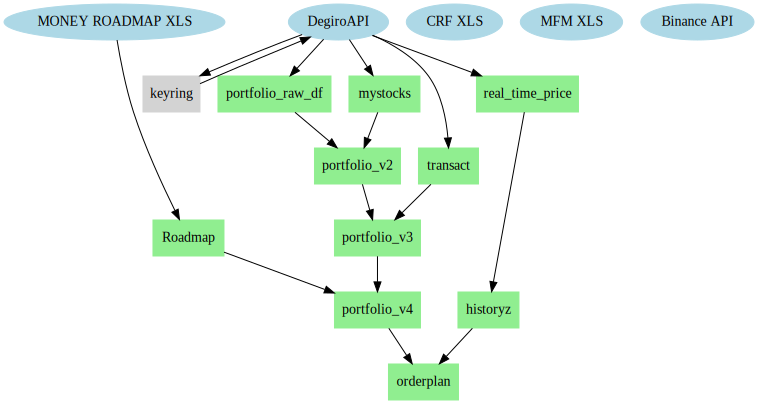

In [307]:
from graphviz import Digraph
u = Digraph(comment='Money',node_attr={'color': 'lightblue', 'style': 'filled'})

with u.subgraph() as s:
    s.attr(rank='same')
    s.node('MONEY ROADMAP XLS')
    s.node('DegiroAPI')
    s.node('CRF XLS')
    s.node('MFM XLS')
    s.node('Binance API')

u.attr('node', shape='box', style='filled', color='lightgrey')
u.node('keyring')
u.attr('node', shape='box', style='filled', color='lightgreen')
u.edge('DegiroAPI','keyring')
u.edge('keyring','DegiroAPI')
u.edge('MONEY ROADMAP XLS','Roadmap')
u.edge('DegiroAPI','portfolio_raw_df')
u.edge('DegiroAPI','transact')
u.edge('DegiroAPI','mystocks')
u.edge('DegiroAPI','real_time_price')
u.edge('portfolio_raw_df','portfolio_v2')
u.edge('mystocks','portfolio_v2')
u.edge('portfolio_v2','portfolio_v3')
u.edge('transact','portfolio_v3')
u.edge('Roadmap','portfolio_v4')
u.edge('portfolio_v3','portfolio_v4')
u.edge('real_time_price','historyz')

u.edge('historyz','orderplan')
u.edge('portfolio_v4','orderplan')

u

## IMPORTS

In [173]:
import keyring
import pandas as pd
import degiroapi
from degiroapi.product import Product
from devgiroapi.order import Order
from degiroapi.utils import pretty_json
import numpy as np
from forex_python.converter import CurrencyRates

pd.set_option('display.max_columns', None)

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"


## LOAD DATA

In [297]:
degiro = degiroapi.DeGiro()
passw = keyring.get_password("degiro", "fabertel")
degiro.login("fabertel", passw)

cashfunds = degiro.getdata(degiroapi.Data.Type.CASHFUNDS)
for data in cashfunds:
    print(data)

portfolio_raw = degiro.getdata(degiroapi.Data.Type.PORTFOLIO, True)

portfolio_raw_df = pd.DataFrame(portfolio_raw)
myportfolio = portfolio_raw_df['id'].tolist()

from datetime import datetime, timedelta
trans = degiro.transactions(datetime(2020, 1, 1), datetime.now())
transact = pd.DataFrame(trans)

mystocks = pd.DataFrame(columns = ['id', 'name', 'isin', 'symbol', 'contractSize', 'productType',
       'productTypeId', 'tradable', 'category', 'currency', 'exchangeId',
       'onlyEodPrices', 'orderTimeTypes', 'buyOrderTypes', 'sellOrderTypes',
       'productBitTypes', 'closePrice', 'closePriceDate', 'feedQuality',
       'orderBookDepth', 'vwdIdentifierType', 'vwdId', 'qualitySwitchable',
       'qualitySwitchFree', 'vwdModuleId']) 

for i in (myportfolioids):
    info = degiro.product_info(i)
    tmp = pd.DataFrame.from_dict(info, orient='index').transpose()
    mystocks = mystocks.append(tmp)
    
mystocks=mystocks[['id', 'name','isin', 'symbol', 'productType', 'category', 'currency', 'closePrice', 'closePriceDate']]

ROADMAP = pd.read_excel ('moneyroadmap.xls')
ROADMAP = ROADMAP[(ROADMAP.GOAL.notnull())]

# degiro.logout()

{'data': {'id': 1363902,
  'intAccount': 111016885,
  'loggedInPersonId': 1366698,
  'clientRole': 'basic',
  'effectiveClientRole': 'basic',
  'contractType': 'PRIVATE',
  'username': 'fabertel',
  'displayName': 'Fabio Bertellotti',
  'email': 'fabio.bertellotti@gmail.com',
  'firstContact': {'firstName': 'Fabio',
   'lastName': 'Bertellotti',
   'displayName': 'Fabio Bertellotti',
   'nationality': 'IT',
   'gender': 'MALE',
   'dateOfBirth': '1975-04-06',
   'placeOfBirth': 'Siena',
   'countryOfBirth': 'IT'},
  'address': {'streetAddress': 'via F.Caracciolo',
   'streetAddressNumber': '22',
   'zip': '50133',
   'city': 'Firenze',
   'country': 'IT'},
  'cellphoneNumber': '+393892882181',
  'locale': 'it_IT',
  'language': 'it',
  'culture': 'IT',
  'bankAccount': {'bankAccountId': 1484866,
   'bic': 'BCITITMMXXX',
   'iban': 'IT51X0306902911000000001960',
   'status': 'VERIFIED'},
  'memberCode': 'AA7042FD',
  'isWithdrawalAvailable': True,
  'isAllocationAvailable': False,
  'is

EUR 2189.44


## CREATE PORTFOLIO

In [186]:
portfolio_v2 = pd.merge(portfolio_raw_df,mystocks,how="left")
portfolio_v2 = portfolio_v2 [['isin', 'symbol','name','value', 'size', 'price','breakEvenPrice','productType', 'category', 'currency','closePrice', 'closePriceDate','id', 'positionType']]
portfolio_v2 = portfolio_v2.sort_values(["productType", "value"], ascending = (True, False))

transactrecap = transact.groupby(['productId']).agg({"price": [np.min,np.mean,np.max],"totalPlusFeeInBaseCurrency": [np.sum],"id": [np.size],"date":[np.min,np.max]}).reset_index()
transactrecap.columns = transactrecap.columns.get_level_values(0) # flatten multiindex df 
transactrecap=transactrecap.set_axis (['productId', 'pricemin', 'pricemean', 'pricemax', 'totalPlusFeeInEur','trans_cnt', 'datemin', 'datemax'], axis=1, inplace=False)
portfolio_v2['id'] = portfolio_v2['id'].astype(np.float64)

portfolio_v3=pd.merge(portfolio_v2,transactrecap,how="left",left_on="id",right_on="productId")
portfolio_v3 = portfolio_v3 [['isin', 'symbol', 'name', 'value','totalPlusFeeInEur', 'size', 'price', 'productType', 'category', 'currency', 'pricemin', 'pricemean', 'pricemax',  'trans_cnt','datemin', 'datemax','breakEvenPrice','closePrice', 'closePriceDate', 'id', 'positionType', 'productId']]
portfolio_v3= portfolio_v3.set_axis (['isin', 'symbol', 'name', 'valuenowCURR','spentEUR', 'size', 'pricenow', 'productType', 'category', 'currency', 'pricebuymin', 'pricebuymean', 'pricebuymax',  'trans_cnt','datemin', 'datemax','breakEvenPrice','closePrice', 'closePriceDate', 'id', 'positionType', 'productId'], axis=1, inplace=False)

TOTACCOUNT=portfolio_v3['valuenowCURR'].sum()
INVESTED = portfolio_v3[(portfolio_v3.symbol!='FSUCEURCSH')]['valuenowCURR'].sum()
NOTINVESTED = portfolio_v3[(portfolio_v3.symbol=='FSUCEURCSH')]['valuenowCURR'].sum()

for index, row in portfolio_v3.iterrows():
    portfolio_v3.at[index, 'investedPerc'] = row['valuenowCURR']/TOTACCOUNT
    portfolio_v3.at[index, 'spentEUR'] = -row['spentEUR']
    portfolio_v3.at[index, 'Delta'] = row['valuenowCURR']+row['spentEUR']
    if (row['spentEUR']!=0):
        portfolio_v3.at[index, 'DeltaPerc'] = -(row['valuenowCURR']+row['spentEUR'])/row['spentEUR']
        
# portfolio_v3['DeltaPerc']=portfolio_v3['DeltaPerc'].map('{:.0%}'.format)
# portfolio_v3['investedPerc']=portfolio_v3['investedPerc'].map('{:.0%}'.format)

colsneworder = ['isin', 'symbol', 'name', 'valuenowCURR','spentEUR','Delta', 'DeltaPerc','investedPerc','size', 'pricenow', 'productType', 'category', 'currency', 'pricebuymin', 'pricebuymean', 'pricebuymax',  'trans_cnt','datemin', 'datemax','breakEvenPrice','closePrice', 'closePriceDate', 'id', 'positionType', 'productId']
portfolio_v3 = portfolio_v3.reindex(columns= colsneworder)
portfolio_v3 = portfolio_v3.sort_values(["productType", "Delta"], ascending = (True, False))

# INVESTED = portfolio_v3[(portfolio_v3.symbol!='FSUCEURCSH')]['spentEUR'].sum()
# NOTINVESTED = portfolio_v2[(portfolio_v2.symbol=='FSUCEURCSH')]['value'].sum()
# DELTA = portfolio_v3[(portfolio_v3.symbol!='FSUCEURCSH')]['Delta'].sum()
# investedPerccc = portfolio_v3['investedPerc'].sum()
# DELTAPERC = (DELTA/INVESTED)
# TOTACCOUNT,INVESTED,NOTINVESTED,DELTA,DELTAPERC,investedPerccc

portfolio_v4 = pd.merge(portfolio_v3,ROADMAP, how = "left" , left_on="isin" , right_on="ISIN")

for index, row in portfolio_v4.iterrows():
    portfolio_v4.at[index, 'GOALinvestment'] = TOTACCOUNT*row['GOAL']
    portfolio_v4.at[index, 'vsGOAL'] = row['valuenowCURR']-(TOTACCOUNT*row['GOAL'])
    portfolio_v4.at[index, 'vsEURrate'] = c.get_rate(row['currency'], 'EUR')  
    portfolio_v4.at[index, 'valuenowEUR'] = (c.get_rate(row['currency'], 'EUR'))*row['valuenowCURR']
    
colsneworder_v4 = ['isin', 'symbol', 'name', 'valuenowCURR','valuenowEUR','spentEUR','Delta', 'DeltaPerc','investedPerc','GOAL', 'GOALinvestment', 'vsGOAL','size', 'pricenow', 'productType', 'category', 'currency','vsEURrate', 'pricebuymin', 'pricebuymean', 'pricebuymax',  'trans_cnt','datemin', 'datemax','breakEvenPrice','closePrice', 'closePriceDate', 'id', 'positionType', 'productId','GOALvsPIANO']
portfolio_v4 = portfolio_v4.reindex(columns= colsneworder_v4)

portfolio_v4   


,isin,symbol,name,valuenowCURR,valuenowEUR,spentEUR,Delta,DeltaPerc,investedPerc,GOAL,GOALinvestment,vsGOAL,size,pricenow,productType,category,currency,vsEURrate,pricebuymin,pricebuymean,pricebuymax,trans_cnt,datemin,datemax,breakEvenPrice,closePrice,closePriceDate,id,positionType,productId,GOALvsPIANO
0,NL0010661914,FSUCEURCSH,EUR Cash Fund FundShare,"2,189.44","2,189.44",nan,nan,nan,0.12,0.05,923.49,"1,265.95","2,231.85",0.98,CASH,D,EUR,1.00,nan,nan,nan,nan,NaN,NaN,0.98,0.98,2021-01-07,"5,173,554.00",CASH,nan,0.05
1,IE00B4L5Y983,SWDA,ISHSIII-CORE MSCI WORLD U.ETF,"7,028.80","7,028.80","6,299.90",728.90,0.12,0.38,0.42,"7,757.31",-728.51,115.00,61.12,ETF,H,EUR,1.00,53.00,54.96,55.95,4.00,2020-10-20T09:04:29+02:00,2020-10-30T15:48:57+01:00,54.70,61.12,2021-01-08,"4,622,784.00",PRODUCT,"4,622,784.00",0.60
2,IE00BF0M2Z96,BATT,L&G BATTERY VALUE-CHAIN UCITS ETF,"1,351.72","1,351.72",904.67,447.05,0.49,0.07,0.06,"1,108.19",243.53,94.00,14.38,ETF,H,EUR,1.00,9.60,9.60,9.60,1.00,2020-10-28T09:04:45+01:00,2020-10-28T09:04:45+01:00,9.60,14.38,2021-01-08,"14,418,200.00",PRODUCT,"14,418,200.00",0.20
3,IE00BYZK4552,RBOT,ISHARES AUTOMAT & ROBOTICS UCITS ETF ACC,"1,091.88","1,091.88",909.47,182.41,0.20,0.06,0.06,"1,108.19",-16.31,108.00,10.11,ETF,H,EUR,1.00,8.40,8.40,8.40,1.00,2020-10-28T09:13:11+01:00,2020-10-28T09:13:11+01:00,8.40,10.11,2021-01-08,"12,063,898.00",PRODUCT,"12,063,898.00",0.20
4,IE00BYWQWR46,ESP0,VANECK ETFS-V.V.VID.GAM.+ESPTS,"1,083.30","1,083.30",943.87,139.43,0.15,0.06,0.06,"1,108.19",-24.89,30.00,36.11,ETF,I,EUR,1.00,31.30,31.59,31.89,2.00,2020-10-09T13:57:25+02:00,2020-10-30T15:16:41+01:00,31.32,36.11,2021-01-08,"16,143,345.00",PRODUCT,"16,143,345.00",0.20
5,IE00B74DQ490,HYLD,ISHARES GLO HIGH YLD CORP UCITS ETF DIST,"1,553.63","1,553.63","1,510.65",42.98,0.03,0.08,0.10,"1,939.33",-385.70,19.00,81.77,ETF,F,EUR,1.00,79.00,79.25,79.60,4.00,2020-10-19T14:06:34+02:00,2020-10-26T09:08:40+01:00,79.17,81.77,2021-01-08,"7,496,799.00",PRODUCT,"7,496,799.00",0.15
6,IE00BD49RB39,EYLD,WisdomTree EUR Agg Bd Enhanced Yield ETF EUR Acc,"1,483.30","1,483.30","1,477.64",5.66,0.00,0.08,0.10,"1,939.33",-456.03,26.00,57.05,ETF,F,EUR,1.00,56.50,56.60,56.70,2.00,2020-10-20T16:56:43+02:00,2020-12-02T09:04:05+01:00,56.66,57.05,2021-01-08,"14,902,751.00",PRODUCT,"14,902,751.00",0.15
7,IE00BYZK4669,AGED,iShares Ageing Population UCITS ETF USD (Acc),24.26,19.81,23.03,1.23,0.05,0.00,0.06,"1,108.19","-1,083.92",4.00,7.41,ETF,H,USD,0.82,6.20,6.20,6.20,1.00,2020-10-09T14:09:21+02:00,2020-10-09T14:09:21+02:00,6.20,7.41,2021-01-08,"11,853,221.00",PRODUCT,"11,853,221.00",0.20
8,IE00B579F325,SGLD,Invesco Physical Gold ETC,735.15,735.15,749.62,-14.47,-0.02,0.04,0.07,"1,292.89",-557.74,5.00,147.03,ETF,A,EUR,1.00,147.00,152.19,157.39,2.00,2020-10-14T17:18:40+02:00,2020-12-03T10:27:23+01:00,149.08,147.03,2021-01-08,"5,396,380.00",PRODUCT,"5,396,380.00",0.10
9,US92556V1061,VTRS,Viatris,104.85,85.59,-0.00,104.85,nan,0.01,nan,nan,nan,7.00,18.30,STOCK,B,USD,0.82,0.00,0.00,0.00,1.00,2020-11-17T00:00:00+01:00,2020-11-17T00:00:00+01:00,0.00,18.30,2021-01-08,"18,584,838.00",PRODUCT,"18,584,838.00",nan


In [187]:
portfolio_v4.to_excel('portfolio_v4.xls')

## HISTORICAL TRENDS

In [305]:
mysymbols = portfolio_v4['symbol'].tolist()
del mysymbols[0]          # remove first value (FSUCEURCSH)

history = pd.DataFrame(columns = ['isin','alfa','cumulativeVolume','market','name','windowHighPrice','windowHighTime','windowLowPrice','windowLowTime','Type','lastPrice'])

for i in (mysymbols):
    products = degiro.search_products(i)

    realprice = degiro.real_time_price(Product(products[0]).id, degiroapi.Interval.Type.One_Week)
    realprice[0]['data']['Type'] = 'One_Week'    # add label to dict 
    tmp = pd.DataFrame.from_dict(realprice[0]['data'], orient='index').transpose()
    colsneworder_v5 = ['isin','alfa','cumulativeVolume','market','name','windowHighPrice','windowHighTime','windowLowPrice','windowLowTime','Type','lastPrice']
    tmp = tmp.reindex(columns= colsneworder_v5)
    history=history.append(tmp)

    realprice = degiro.real_time_price(Product(products[0]).id, degiroapi.Interval.Type.One_Month)
    realprice[0]['data']['Type'] = 'One_Month'
    tmp = pd.DataFrame.from_dict(realprice[0]['data'], orient='index').transpose()
    colsneworder_v5 = ['isin','alfa','cumulativeVolume','market','name','windowHighPrice','windowHighTime','windowLowPrice','windowLowTime','Type','lastPrice']
    tmp = tmp.reindex(columns= colsneworder_v5)
    history=history.append(tmp)

    realprice = degiro.real_time_price(Product(products[0]).id, degiroapi.Interval.Type.One_Year)
    realprice[0]['data']['Type'] = 'One_Year'
    tmp = pd.DataFrame.from_dict(realprice[0]['data'], orient='index').transpose()
    colsneworder_v5 = ['isin','alfa','cumulativeVolume','market','name','windowHighPrice','windowHighTime','windowLowPrice','windowLowTime','Type','lastPrice']
    tmp = tmp.reindex(columns= colsneworder_v5)
    history=history.append(tmp)


In [306]:
historyz = pd.DataFrame([y.values.ravel() for x , y in history.groupby(np.arange(len(history))//3)])

historyz.columns= ['isin', 'alfa', 'cumulativeVolume', 'market', 'name', 'windowHighPrice','windowHighTime', 'windowLowPrice', 'windowLowTime', 'Type','lastPrice',
 'isin1', 'alfa1', 'cumulativeVolume1', 'market1', 'name1','windowHighPrice1','windowHighTime1', 'windowLowPrice1', 'windowLowTime1', 'Type1','lastPrice1',
'isin2', 'alfa2', 'cumulativeVolume2', 'market2', 'name2', 'windowHighPrice2','windowHighTime2', 'windowLowPrice2', 'windowLowTime2', 'Type2','lastPrice2']

historyz = historyz.drop(['isin1', 'alfa1', 'cumulativeVolume1', 'market1', 'name1','lastPrice1'] ,  axis='columns')
historyz = historyz.drop(['isin2', 'alfa2', 'cumulativeVolume2', 'market2', 'name2','lastPrice2'] ,  axis='columns')

historyz= historyz.set_axis (['isin', 'alfa', 'cumVol', 'market', 'name', 
'1W_H','1W_HT', '1W_L', '1W_LT', 'Type','lastPrice',
'1M_H','1M_HT', '1M_L', '1M_LT', 'Type',
'1Y_H','1Y_HT', '1Y_L', '1Y_LT', 'Type'], axis=1, inplace=False)

for index, row in historyz.iterrows():
    historyz.at[index, 'vs_1W'] = (row['lastPrice']-row['1W_L'])/(row['1W_H']-row['1W_L'])
    historyz.at[index, 'vs_1M'] = (row['lastPrice']-row['1M_L'])/(row['1M_H']-row['1M_L'])
    historyz.at[index, 'vs_1Y'] = (row['lastPrice']-row['1Y_L'])/(row['1Y_H']-row['1Y_L'])

historyz
# historyz.to_excel('historyz.xls')

,isin,alfa,cumVol,market,name,1W_H,1W_HT,1W_L,1W_LT,Type,lastPrice,1M_H,1M_HT,1M_L,1M_LT,Type,1Y_H,1Y_HT,1Y_L,1Y_LT,Type,vs_1W,vs_1M,vs_1Y
0,IE00B4L5Y983,B300099702,"45,000.00",ETFP,iShares Core MSCI World UCITS ETF,61.12,2021-01-08T00:00:00,59.31,2021-01-04T00:00:00,One_Week,61.12,61.12,2021-01-08T00:00:00,58.57,2020-12-21T00:00:00,One_Month,61.12,2021-01-08T00:00:00,40.23,2020-03-23T00:00:00,One_Year,1.00,1.00,1.00
1,IE00BKLF1R75,VOL,"83,244.00",ETFP,WISDOMTREE BATTERY SOLUTIONS UCITS ETF,40.59,2021-01-08T00:00:00,37.05,2021-01-04T00:00:00,One_Week,40.59,40.59,2021-01-08T00:00:00,32.27,2020-12-11T00:00:00,One_Month,40.59,2021-01-08T00:00:00,15.73,2020-03-23T00:00:00,One_Year,1.00,1.00,1.00
2,IE00BYZK4552,RBO2,"116,664.00",ETFP,ISHARES AUTOMAT & ROBOTICS UCITS ETF ACC,10.10,2021-01-08T00:00:00,9.69,2021-01-04T00:00:00,One_Week,10.10,10.10,2021-01-08T00:00:00,9.35,2020-12-11T00:00:00,One_Month,10.10,2021-01-08T00:00:00,5.32,2020-03-18T00:00:00,One_Year,1.00,1.00,1.00
3,IE00BYWQWR46,AP182,"136,304.00",XETR,VANECK ETFS-V.V.VID.GAM.+ESPTS,36.11,2021-01-08T00:00:00,34.95,2021-01-04T00:00:00,One_Week,36.11,36.11,2021-01-08T00:00:00,33.65,2020-12-10T00:00:00,One_Month,36.11,2021-01-08T00:00:00,18.50,2020-03-12T00:00:00,One_Year,1.00,1.00,1.00
4,IE00B74DQ490,IG4,"1,245.00",ETFP,ISHARES GLO HIGH YLD CORP UCITS ETF DIST,81.77,2021-01-08T00:00:00,81.11,2021-01-05T00:00:00,One_Week,81.77,81.77,2021-01-08T00:00:00,80.76,2020-12-21T00:00:00,One_Month,89.70,2020-02-20T00:00:00,67.04,2020-03-23T00:00:00,One_Year,1.00,1.00,0.65
5,IE00BD49RB39,EYL,9.00,ETFP,WISDOMTREE EUR AG BO ENH UCITS ETF EUR A,57.18,2021-01-04T00:00:00,56.96,2021-01-07T00:00:00,One_Week,57.02,57.22,2020-12-15T00:00:00,56.93,2020-12-23T00:00:00,One_Month,57.22,2020-12-15T00:00:00,50.64,2020-03-23T00:00:00,One_Year,0.27,0.31,0.97
6,FR0010592014,B360248388,"359,898.00",XPAR,Lyxor ETF Leverage CAC 40,20.81,2021-01-08T00:00:00,19.83,2021-01-05T00:00:00,One_Week,20.81,20.81,2021-01-08T00:00:00,18.58,2020-12-21T00:00:00,One_Month,25.61,2020-02-19T00:00:00,9.24,2020-03-18T00:00:00,One_Year,1.00,1.00,0.71
7,IE00B579F325,SGLD,"228,705.00",XLON,INV PHYS GOLD,188.69,2021-01-05T00:00:00,180.00,2021-01-08T00:00:00,One_Week,180.08,188.69,2021-01-05T00:00:00,176.91,2020-12-14T00:00:00,One_Month,198.91,2020-08-06T00:00:00,143.26,2020-03-19T00:00:00,One_Year,0.01,0.27,0.66
8,US92556V1061,VIA3,0.00,XNAS,Viatris,nan,None,nan,None,One_Week,nan,nan,None,nan,None,One_Month,nan,None,nan,None,One_Year,nan,nan,nan
9,US7170811035,PFE,"33,462,370.00",XNYS,Pfizer Inc,37.19,2021-01-05T00:00:00,36.81,2021-01-04T00:00:00,One_Week,37.13,41.85,2020-12-09T00:00:00,36.74,2020-12-22T00:00:00,One_Month,42.56,2020-12-08T00:00:00,28.49,2020-03-23T00:00:00,One_Year,0.84,0.08,0.61


## ORDINI

In [ ]:
from datetime import datetime, timedelta

orders = degiro.orders(datetime.now() - timedelta(days=90), datetime.now())
orders_log = pd.DataFrame(orders)
orders_log

## BACKUP

In [181]:
# getting realtime and historical data from a stock
products = degiro.search_products('PFE')
products

[{'id': '332062',
  'name': 'Pfizer Inc',
  'isin': 'US7170811035',
  'symbol': 'PFE',
  'contractSize': 1.0,
  'productType': 'STOCK',
  'productTypeId': 1,
  'tradable': True,
  'category': 'A',
  'currency': 'USD',
  'exchangeId': '676',
  'onlyEodPrices': False,
  'orderTimeTypes': ['DAY', 'GTC'],
  'buyOrderTypes': ['LIMIT', 'MARKET', 'STOPLOSS', 'STOPLIMIT'],
  'sellOrderTypes': ['LIMIT', 'MARKET', 'STOPLOSS', 'STOPLIMIT'],
  'productBitTypes': ['US_RAS_GREEN_LIST'],
  'closePrice': 37.13,
  'closePriceDate': '2021-01-08',
  'feedQuality': 'BT',
  'orderBookDepth': 0,
  'vwdIdentifierType': 'vwdkey',
  'vwdId': 'PFE.BATS,E',
  'qualitySwitchable': False,
  'qualitySwitchFree': False,
  'vwdModuleId': 31,
  'feedQualitySecondary': 'D15',
  'orderBookDepthSecondary': 0,
  'vwdIdentifierTypeSecondary': 'issueid',
  'vwdIdSecondary': '330016502',
  'qualitySwitchableSecondary': False,
  'qualitySwitchFreeSecondary': False,
  'vwdModuleIdSecondary': 10}]

In [ ]:
i=0
for index, row in FINAL.iterrows():
    FINAL.at[i, 'GAMEDATE2'] = datetime.datetime.strptime(row['GAMEDATE'], '%d/%m/%Y')
    FINAL.at[i, 'GAMETEAMS'] = row['TEAMH']+row['TEAMA']
    FINAL.at[i, 'WINNER_ID'] = round(row['resultRF'])
    if (round(row['resultRF'])==0):    #1 TEAMH , 0 TEAMA
        win=row['TEAMA']
    else:

In [131]:
sp5symbols = []
products = degiro.get_stock_list(14, 846)
for product in products:
    sp5symbols.append(Product(product).symbol)
    
